<a href="https://colab.research.google.com/github/kathuman/Python-Experiments/blob/main/201228_MArkowitzk_Efficient_frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# https://www.linkedin.com/pulse/markowitz-portfolio-optimization-python-f%C3%A1bio-neves/
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as spy

In [38]:
start_date = '2019-01-01'
end_date = '2020-12-23'
tickers = ['NZYM-B.CO', 'DANSKE.CO', 'NOVO-B.CO', 'ORSTED.CO']
for idx, ticker in enumerate(tickers):
  data_ticker = pdr.DataReader(ticker, 'yahoo', start_date, end_date)['Close']
  if idx == 0:
    data = data_ticker
  else:
    data = pd.concat([data, data_ticker], axis=1)
data.columns = tickers
data

,NZYM-B.CO,DANSKE.CO,NOVO-B.CO,ORSTED.CO
Date,,,,
2019-01-02,288.100006,128.699997,304.299988,428.100006
2019-01-03,285.500000,128.399994,310.000000,436.000000
2019-01-04,293.100006,133.850006,312.649994,438.299988
2019-01-07,292.500000,133.500000,312.399994,439.899994
2019-01-08,298.899994,132.850006,314.500000,440.200012
...,...,...,...,...
2020-12-17,342.600006,96.099998,437.450012,1107.000000
2020-12-18,350.200012,97.779999,446.399994,1110.500000
2020-12-21,349.899994,99.820000,437.149994,1125.500000


In [39]:
# Normalize the dta using logarithmic returns
log_ret = np.log(data/data.shift(1))
log_ret.head()

,NZYM-B.CO,DANSKE.CO,NOVO-B.CO,ORSTED.CO
Date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.009066,-0.002334,0.018558,0.018285
2019-01-04,0.026272,0.041569,0.008512,0.005261
2019-01-07,-0.002049,-0.002618,-0.000800,0.003644
2019-01-08,0.021644,-0.004881,0.006700,0.000682


In [40]:
# We now simulate several combinations of portfolios for the chosen tickers
np.random.seed(42)
num_ports = 6000 # number of portfolios to simulate
all_weights = np.zeros((num_ports, len(data.columns)))
ret_arr = np.zeros(num_ports) # Expected returns
vol_arr = np.zeros(num_ports) # Expected volatility
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
  #weights
  weights = np.array(np.random.random(4))
  weights = weights/np.sum(weights)

  #save weights
  all_weights[x,:] = weights
  
  # Expected returns
  ret_arr[x] = np.sum((log_ret.mean()*weights*252))

  #Expected volatility
  vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))

  # Sharpe Ratio
  sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [41]:
print('Maximum Sharpe ratio: {}'.format(sharpe_arr.max()))
print('Its location in the array: {}'.format(sharpe_arr.argmax()))

Maximum Sharpe ratio: 1.7119473325091945
Its location in the array: 3828


In [42]:
# let us now get all the maximum ratios at this location
print(all_weights[sharpe_arr.argmax(),:])

[0.13704351 0.01048518 0.1446454  0.70782591]


In [43]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

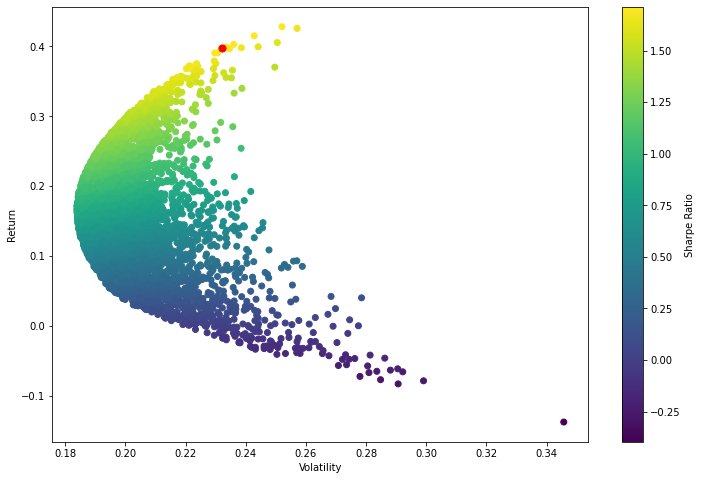

In [44]:
# let us print the efficient frontier, by drawing all the combinations
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50) #the red dot
plt.show()

In [46]:
def get_ret_vol_sr(weights):
  weights = np.array(weights)
  ret = np.sum(log_ret.mean()*weights)*252
  vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
  sr = ret/vol 
  return np.array([ret,vol,sr])

def neg_sharpe(weights):
  return get_ret_vol_sr(weights)[2]*-1

def check_sum(weights):
  return np.sum(weights)-1

In [48]:
cons = ({'type': 'eq', 'fun': check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

In [51]:
opt_results = spy.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.7794343064089628
     jac: array([ 9.14374739e-02,  9.55901384e-01, -1.61513686e-04,  8.01682472e-06])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.00000000e+00, 2.71646939e-16, 4.71145296e-02, 9.52885470e-01])


In [53]:
get_ret_vol_sr(opt_results.x) 
#this optimized value is a bit better than the one obtained by randomly generting portfolio strategies

array([0.49322283, 0.27717957, 1.77943431])

In [54]:
# Let us now check all the optimal portfolios
frontier_y = np.linspace(0,0.3,200)

In [57]:
def minimize_volatility(weights):
  return get_ret_vol_sr(weights)[1]

In [58]:
frontier_x = []

for possible_return in frontier_y:
  cons = ({'type':'eq', 'fun': check_sum},
          {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0]-possible_return})
  result = spy.minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
  frontier_x.append(result['fun'])

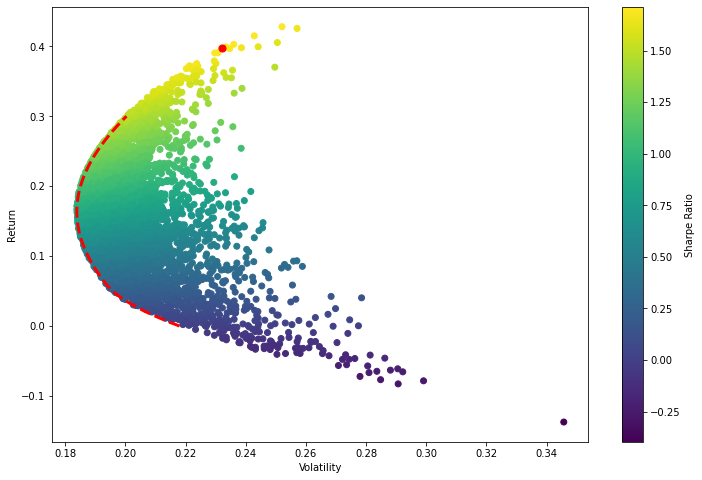

In [60]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50) #the red dot
plt.show()